<a href="https://colab.research.google.com/github/angeruzzi/CompeticoesML/blob/main/6a_Flai_202111_2o_lugar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VI Competição Flai de Machine Learning
Modelo que obteve o 2º Lugar na Competição
---------------------------------
**Autor**: [Alessandro S. Angeruzzi](https://www.linkedin.com/in/alessandroangeruzzi/)

**Licença**: Creative Commons

---------------------------------
Na VI Competição de Machine Learning da Comunidade Flai, que ocorreu entre os dias 28/10/2021 a 28/11/2021 e contou com a participação das turmas de 1 a 6, o desafio proposto foi um problema de Turnover, onde a partir de dados históricos de uma empresa era necessário predizer se um funcionário iria sair nos próximos 2 anos.

Cada participante possuia um limite de 10 submissões dos dados de teste de predição e recebia uma pontuação de acordo com o F1-Score obtido.
Com o modelo abaixo consegui ficar na 2ª posição do ranking final.


##Bibliotecas

In [47]:
#Bibliotecas Base
import pandas as pd
import numpy as np

#Análise
import matplotlib.pyplot as plt
import seaborn as sns
!pip install sweetviz 
import sweetviz as sv

#Modelagem
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import VotingClassifier

#Tunagem
from sklearn.model_selection import GridSearchCV

#Validação
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score

#Balanceamento
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

###Funções úteis

In [48]:
#Comparação de Modelos de Classificação
def CompareML(X, y, lista_de_modelos, nome_dos_modelos, validacao):
  lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
  nome_das_medidas = ['acurácia', 'sensibilidade', 'precisão', 'eficiência', 'f1-score']
  resultados0 = {}
  
  for i in range(len(lista_de_modelos)):
      print('Rodando modelo: ' + nome_dos_modelos[i])
      accs_vc = cross_validate(lista_de_modelos[i], X, y, cv = validacao, scoring = lista_de_medidas)

      acc = accs_vc['test_accuracy'].mean()
      sen = accs_vc['test_recall'].mean()
      vpp = accs_vc['test_precision'].mean()
      bac = accs_vc['test_balanced_accuracy'].mean()
      f1s = accs_vc['test_f1'].mean()

      resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, bac, f1s]
      
  resultados = pd.DataFrame(resultados0, index = nome_das_medidas).T
  return resultados

In [49]:
#Seleção de Features
def SelectFeatures(modelo, dadosX, dadosy, validacaoS, features, score):
  i = 0
  resultados = pd.DataFrame(columns=['Qtd','Performance'])
  for n in np.arange(2,features.count()+1):
    featuresS = features.iloc[0:n].index.tolist()
    dadosSX = dadosX[featuresS]  
    testes = cross_validate(modelo, dadosSX, dadosy, cv=validacaoS, scoring=score)
    r2 = testes['test_score'].mean()
    resultados.loc[i] = [n, r2]
    i += 1
  return resultados

In [50]:
#Tunagem de Hiperparâmetros 
def Tunagem(modelo, treino, targets, parametros, validacao, score):    
    search = GridSearchCV(modelo, param_grid = parametros,
                                  scoring = score, cv = validacao, 
                                  verbose = 1, n_jobs = -1)
    search.fit(treino, targets) 
    bestModel = search.best_estimator_
    bestScore = search.best_score_
    bestParam = search.best_params_

    return {
            'bestModel': bestModel,
            'bestScore': bestScore,
            'bestParam': bestParam
    }

###Modelos Base para Comparação

In [51]:
#mod_logreg     = LogisticRegression()
mod_dtree      = DecisionTreeClassifier()
mod_knn        = KNeighborsClassifier()
mod_rfor       = RandomForestClassifier()
mod_bag        = BaggingClassifier()
#mod_svc        = SVC()
mod_gau        = GaussianNB()
mod_gbc        = GradientBoostingClassifier() 
mod_lgbm       = LGBMClassifier() 
mod_ada        = AdaBoostClassifier()

lista_de_modelosBase = [
    #mod_logreg,
    mod_dtree,
    mod_knn,
    mod_rfor,   
    mod_bag,
    #mod_svc,
    mod_gau,
    mod_gbc,
    mod_lgbm,
    mod_ada
]

nome_dos_modelosBase = [
  #'Regressao Log.'
  'Decision Tree',
  'KNN',
  'Randon Forest',
  'Bagging',
  #'SVC',
  'GaussianNB',
  'GradientBoostingClassifier',
  'LGBM',
  'ADA'
]

#Os modelos de Regressão Logística e SVC apresentaram erros de convergência nos testes

##Dados

In [52]:
#Base de Dados
fonte_treino = 'https://raw.githubusercontent.com/angeruzzi/Datasource/main/DesafioDDS202111_treino.csv'
fonte_teste  = 'https://raw.githubusercontent.com/angeruzzi/Datasource/main/DesafioDDS202111_teste.csv'
ds_treino  = pd.read_csv(fonte_treino) 
ds_teste  = pd.read_csv(fonte_teste) 

##Análise dos dados

In [53]:
#Lista de Campos e Tipos
#Base de treino
ds_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Escolaridade  2916 non-null   object
 1   Entrada       2916 non-null   int64 
 2   Cidade        2916 non-null   object
 3   Salário       2916 non-null   int64 
 4   Idade         2916 non-null   object
 5   Sexo          2916 non-null   object
 6   Projeto       2916 non-null   object
 7   Experiência   2916 non-null   int64 
 8   Saiu          2916 non-null   int64 
 9   Feedbacks     2916 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 227.9+ KB


In [54]:
#Base de Teste
ds_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Escolaridade  1737 non-null   object
 1   Entrada       1737 non-null   int64 
 2   Cidade        1737 non-null   object
 3   Salário       1737 non-null   int64 
 4   Idade         1737 non-null   object
 5   Sexo          1737 non-null   object
 6   Projeto       1737 non-null   object
 7   Experiência   1737 non-null   int64 
 8   Feedbacks     1737 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 122.3+ KB


9 features: 
* Escolaridade: grau de escolaridade do funcionário.
* Entrada: ano de entrada na empresa.
* Cidade: cidade em que o funcionário mora.
* Salário: classe de salário que o funcionário recebe (1 > 2 > 3).
* Idade: idade em anos do funcionário.
* Sexo: sexo do funcionário.
* Projeto: se o funcionário já ficou sem projetos por 1 mês ou mais
* Experiência: anos de experiência que o funcionário possui na área que atua
* Feedbacks: número de feedbacks negativos recebidos pelo funcionário.

Variável Alvo:
* Saiu: se o funcionário saiu da empresa antes de 2 anos de casa (0: não, 1: sim)

In [55]:
#Exemplo de Registros
#Base de Treino
ds_treino.head()

,Escolaridade,Entrada,Cidade,Salário,Idade,Sexo,Projeto,Experiência,Saiu,Feedbacks
0,Doutorado,2016,Natal,3,28,Feminino,Não,3,0,0
1,Doutorado,2014,Natal,3,36,Feminino,Não,3,0,1
2,Doutorado,2013,Natal,3,---,Masculino,Não,0,0,0
3,Doutorado,2016,Natal,3,---,Masculino,Não,2,1,0
4,Doutorado,2018,Natal,3,34,Masculino,Sim,5,1,0


In [56]:
#Verificando os valores possiveis das Features do Dataset de Treino
for coluna in ds_treino.columns:
    print(coluna)
    print(ds_treino[coluna].unique())
    print("-"*100)

Escolaridade
['Doutorado' '---']
----------------------------------------------------------------------------------------------------
Entrada
[2016 2014 2013 2018 2012 2017 2015]
----------------------------------------------------------------------------------------------------
Cidade
['Natal' 'João Pessoa' 'Recife']
----------------------------------------------------------------------------------------------------
Salário
[3 2 1]
----------------------------------------------------------------------------------------------------
Idade
['28' '36' '---' '34' '26' '27' '29' '24' '35' '30' '33' '39' '25' '41'
 '40' '32' '38' '31' '37' '23' '22']
----------------------------------------------------------------------------------------------------
Sexo
['Feminino' 'Masculino']
----------------------------------------------------------------------------------------------------
Projeto
['Não' 'Sim' '---']
---------------------------------------------------------------------------------------

In [57]:
#Base de Teste
ds_teste.head()

,Escolaridade,Entrada,Cidade,Salário,Idade,Sexo,Projeto,Experiência,Feedbacks
0,Doutorado,2017,Recife,2,26,Masculino,Não,4,0
1,---,2017,Recife,3,26,Feminino,Não,4,0
2,Doutorado,2013,Natal,3,27,Masculino,Não,5,0
3,Doutorado,2014,Natal,3,26,Masculino,Não,4,0
4,Doutorado,2013,João Pessoa,2,---,Feminino,Não,0,0


In [58]:
for coluna in ds_teste.columns:
    print(coluna)
    print(ds_teste[coluna].unique())
    print("-"*100)

Escolaridade
['Doutorado' '---']
----------------------------------------------------------------------------------------------------
Entrada
[2017 2013 2014 2015 2016 2012 2018]
----------------------------------------------------------------------------------------------------
Cidade
['Recife' 'Natal' 'João Pessoa']
----------------------------------------------------------------------------------------------------
Salário
[2 3 1]
----------------------------------------------------------------------------------------------------
Idade
['26' '27' '---' '28' '29' '30' '36' '37' '35' '32' '39' '31' '40' '41'
 '34' '38' '33' '22' '25' '23' '24']
----------------------------------------------------------------------------------------------------
Sexo
['Masculino' 'Feminino']
----------------------------------------------------------------------------------------------------
Projeto
['Não' '---' 'Sim']
---------------------------------------------------------------------------------------

As features com dados faltantes do dataset de treino são as mesmas do dataset de teste, sendo assim obrigatoriamente deve-se determinar um tratamento para as mesmas não podendo ser ignoradas.

                                             |          | [  0%]   00:00 -> (? left)


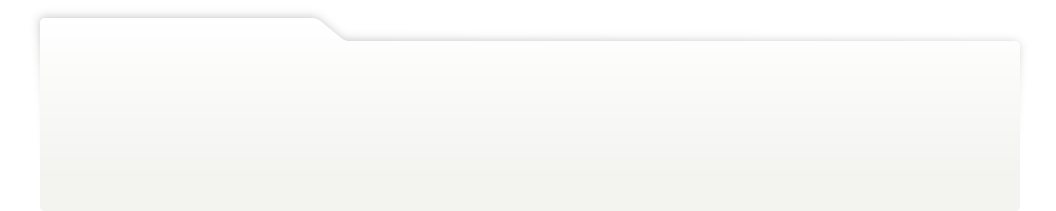
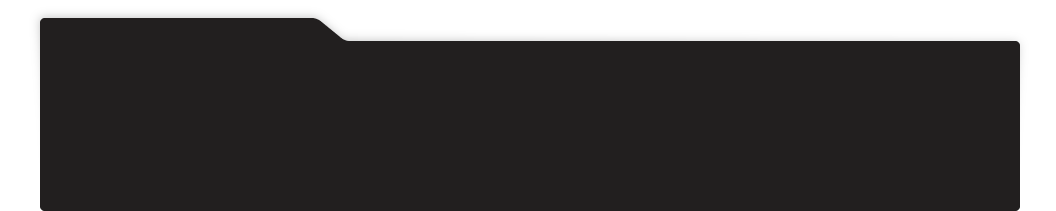
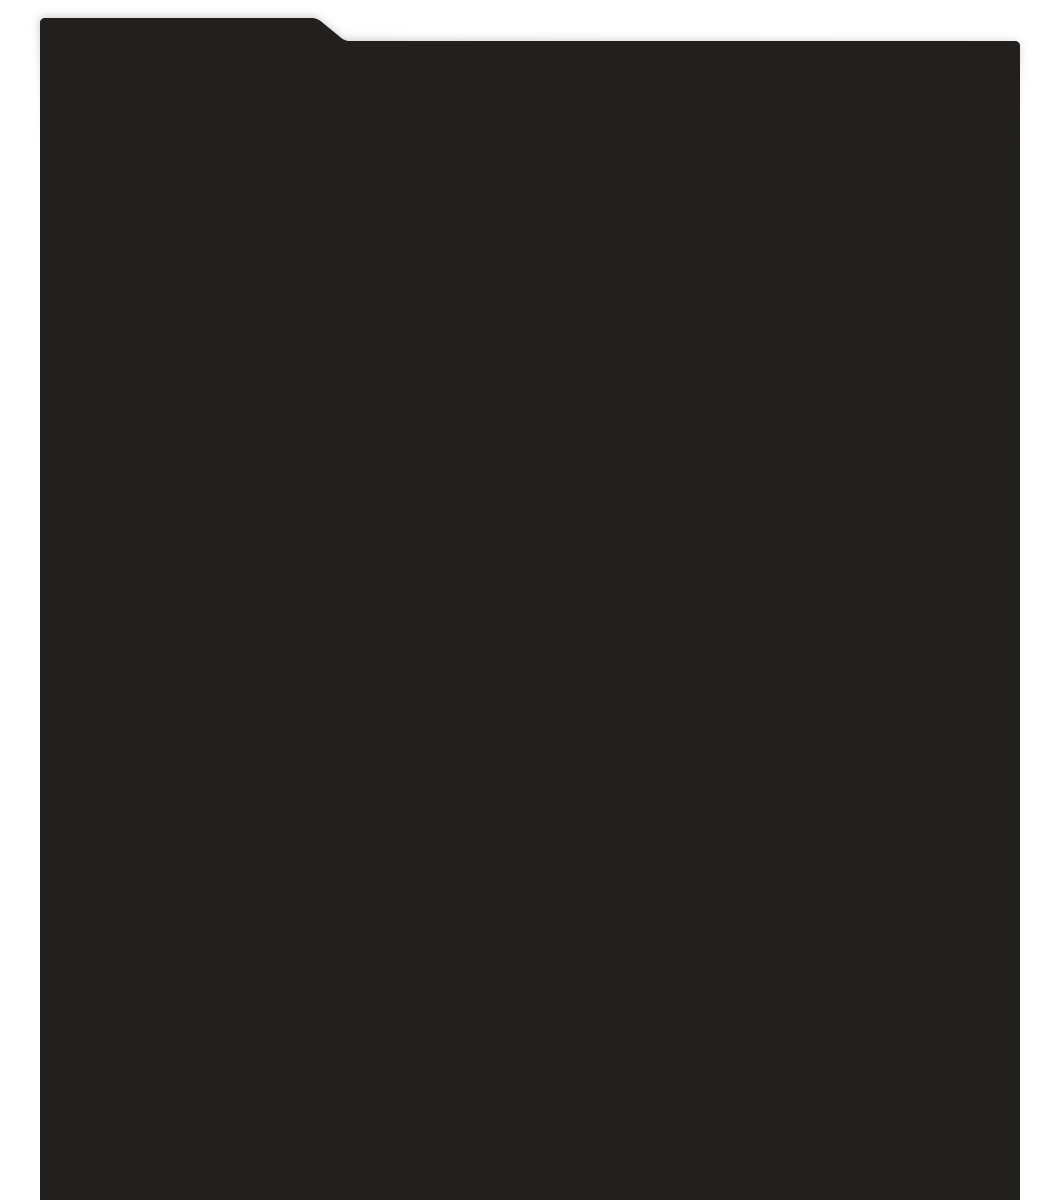
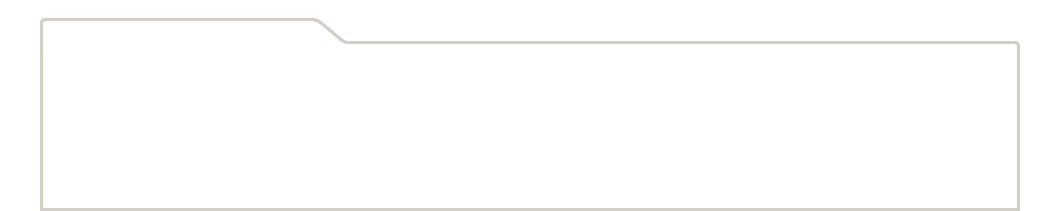
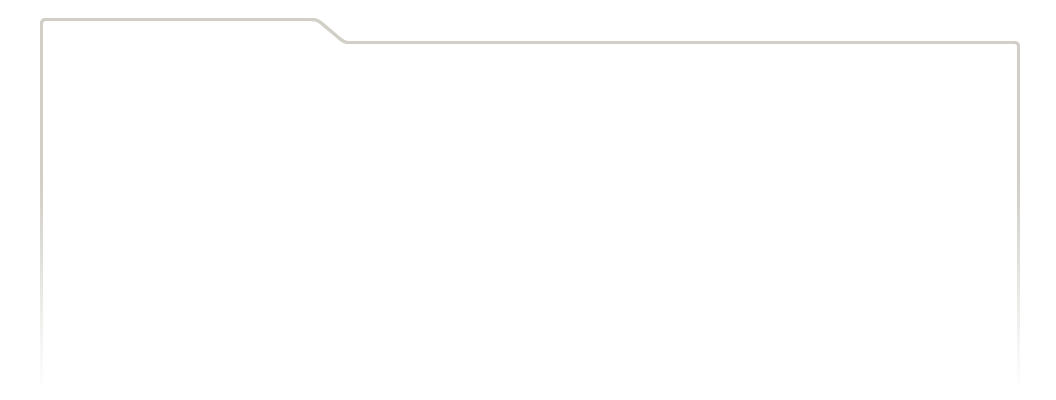
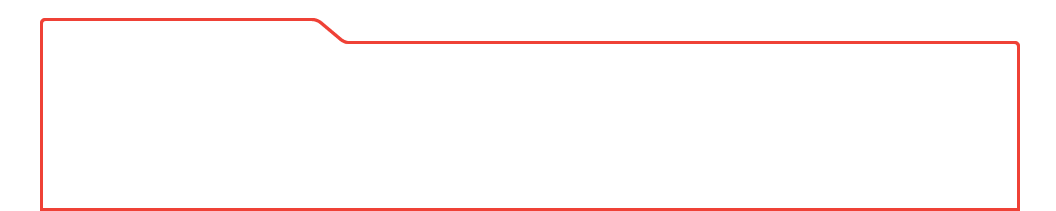
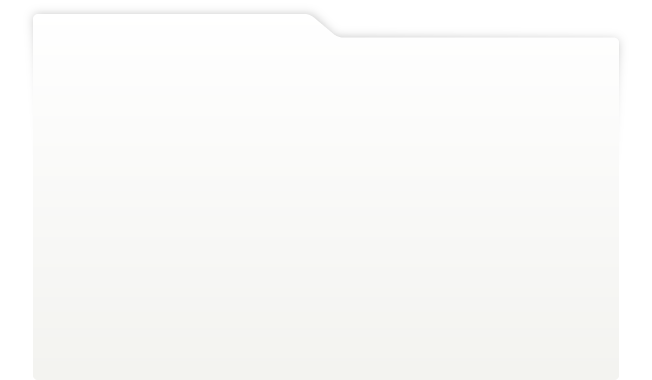
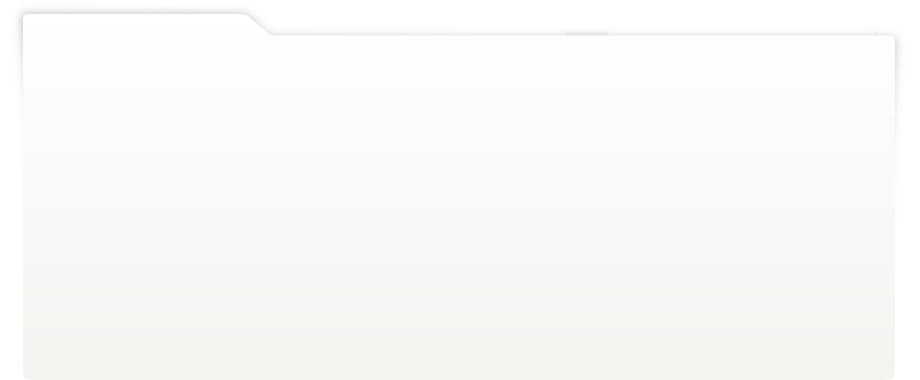
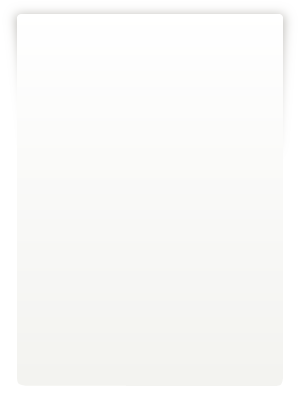
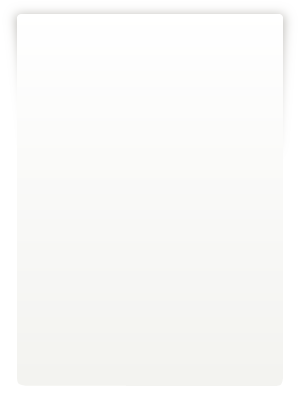
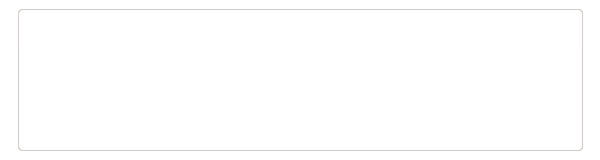
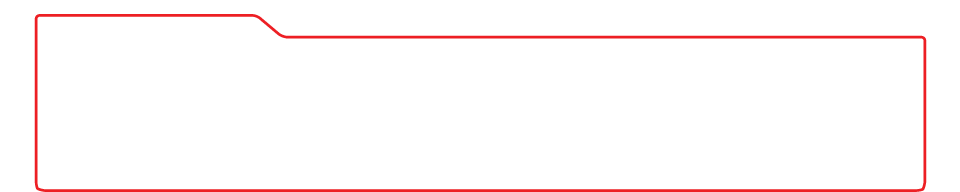
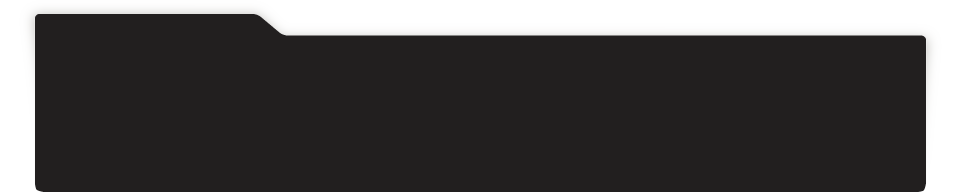
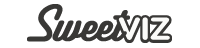
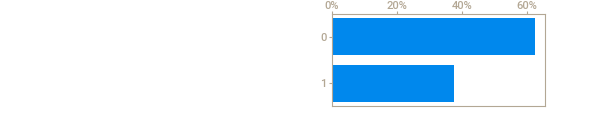
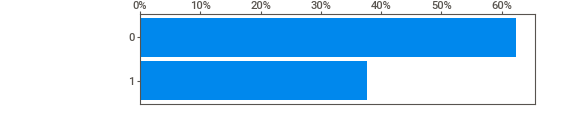
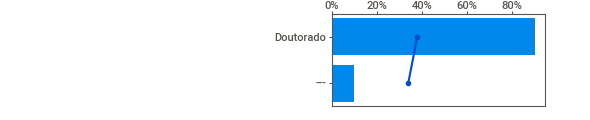
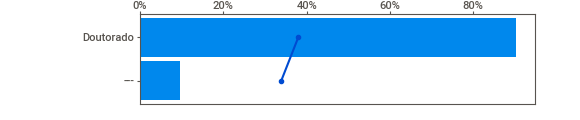
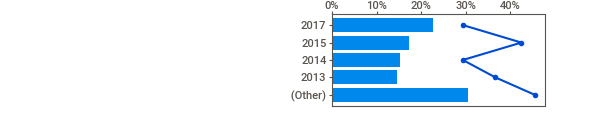
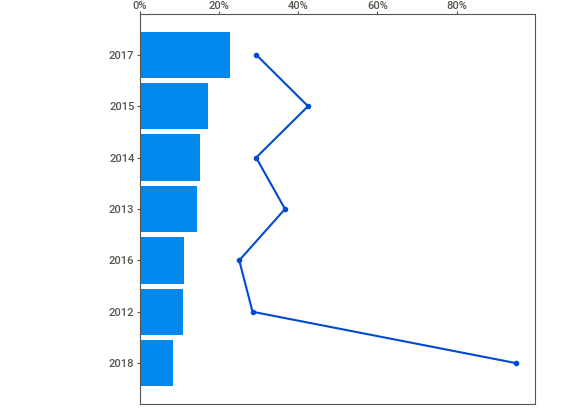
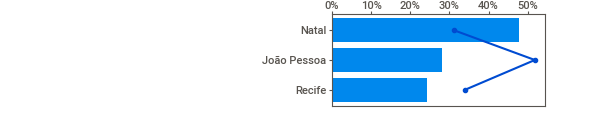
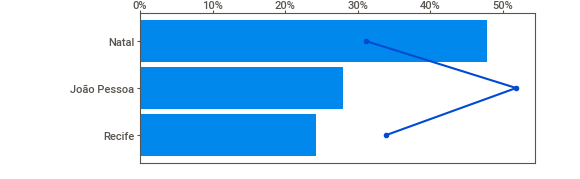
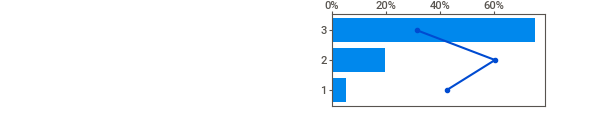
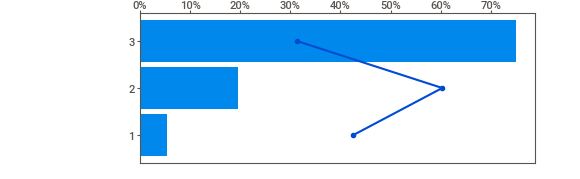
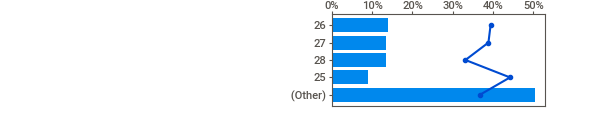
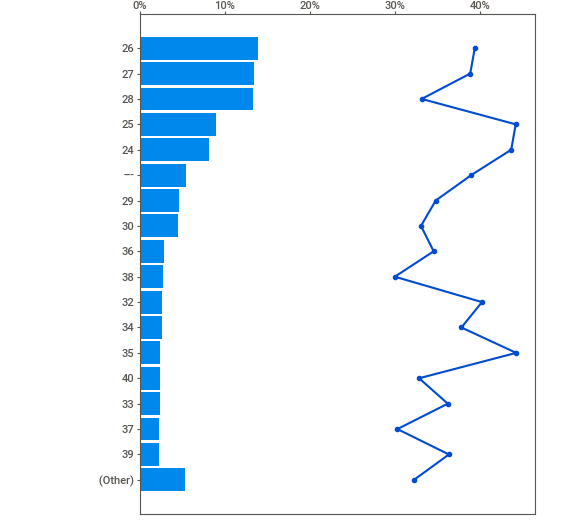
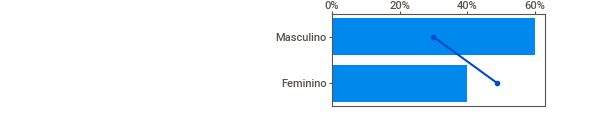
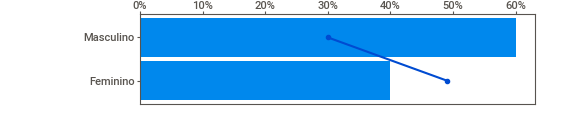
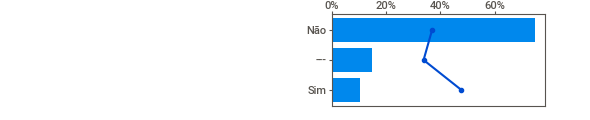
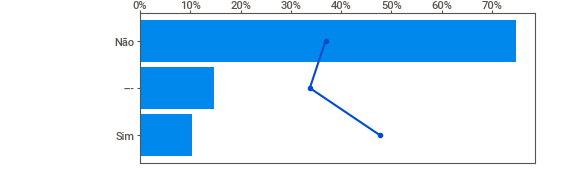
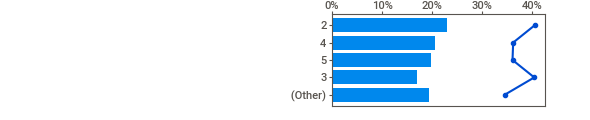
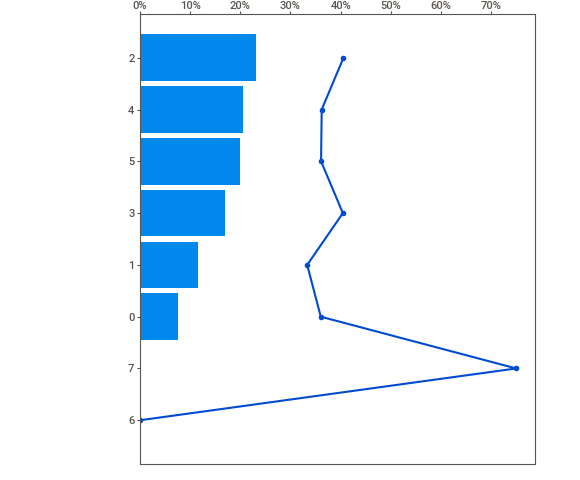
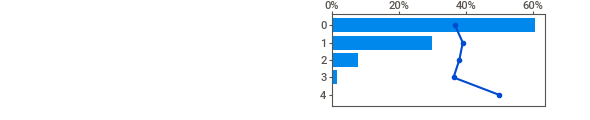
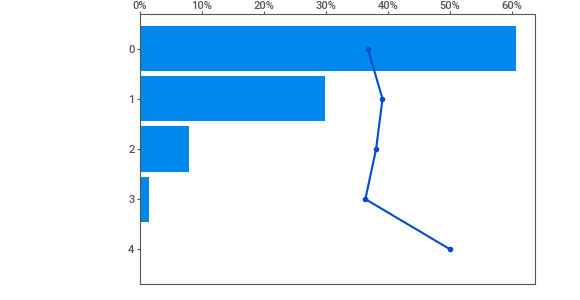
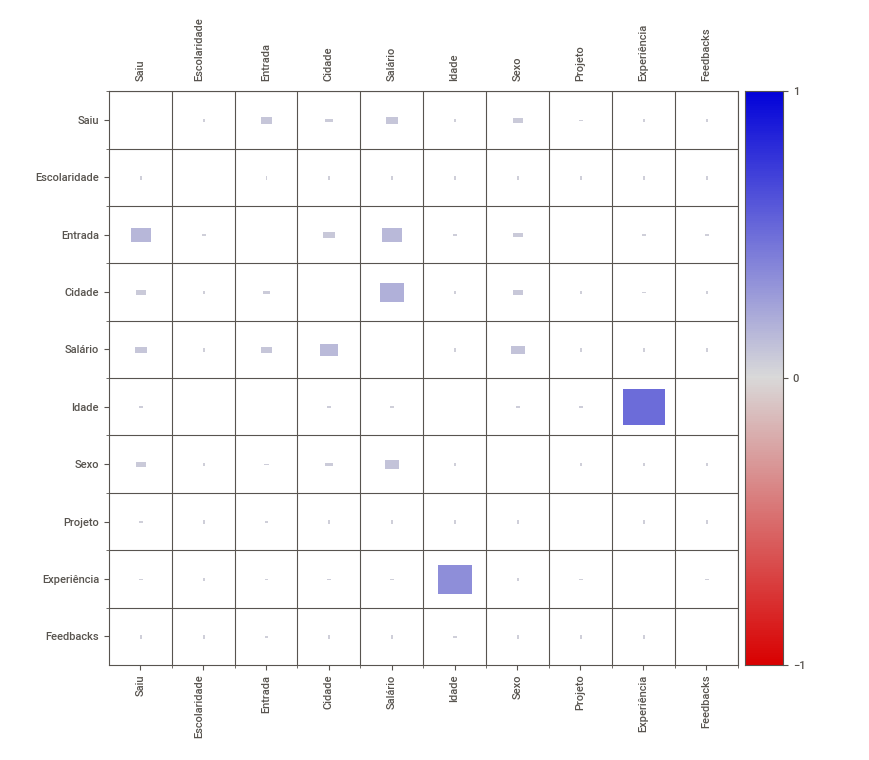
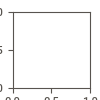

In [59]:
eda = sv.analyze(source = ds_treino, 
                 target_feat = 'Saiu')
eda.show_notebook()

Pela análise prévia já é possível determinar um desbalanceamento dos dados em relação a variável alvo, e também nas features: Escolaridade, Salário e Projeto. 

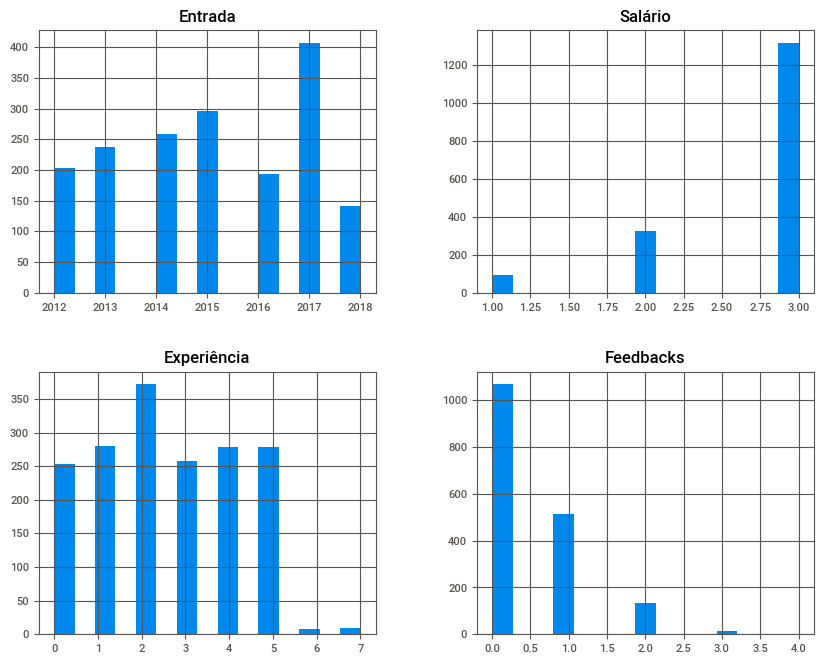

In [60]:
#Histogramas das variáveis numéricas da Base de Teste
ds_teste.hist(bins=15, figsize=(10,8))
plt.show()

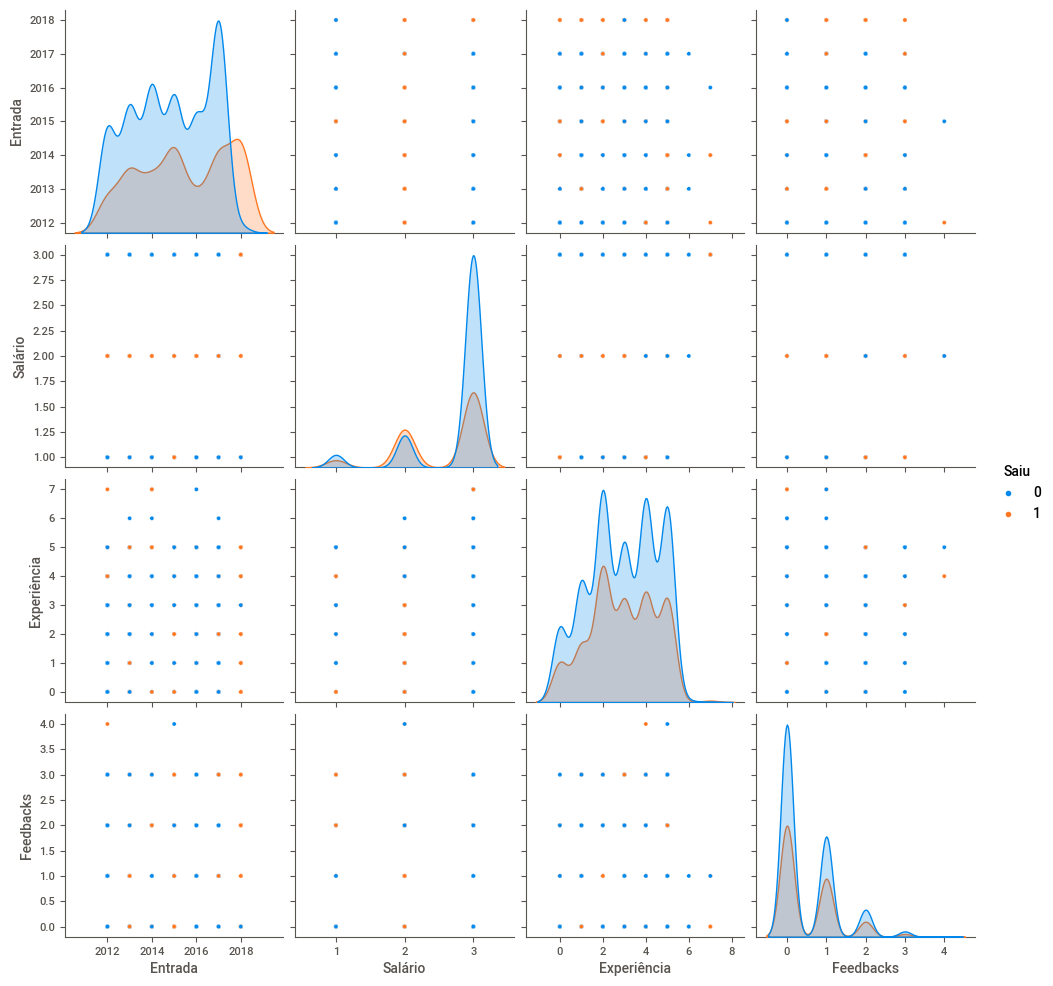

In [61]:
#Relação das features duas a duas / Base de Treino
sns.pairplot(data = ds_treino, hue = "Saiu")
plt.show()

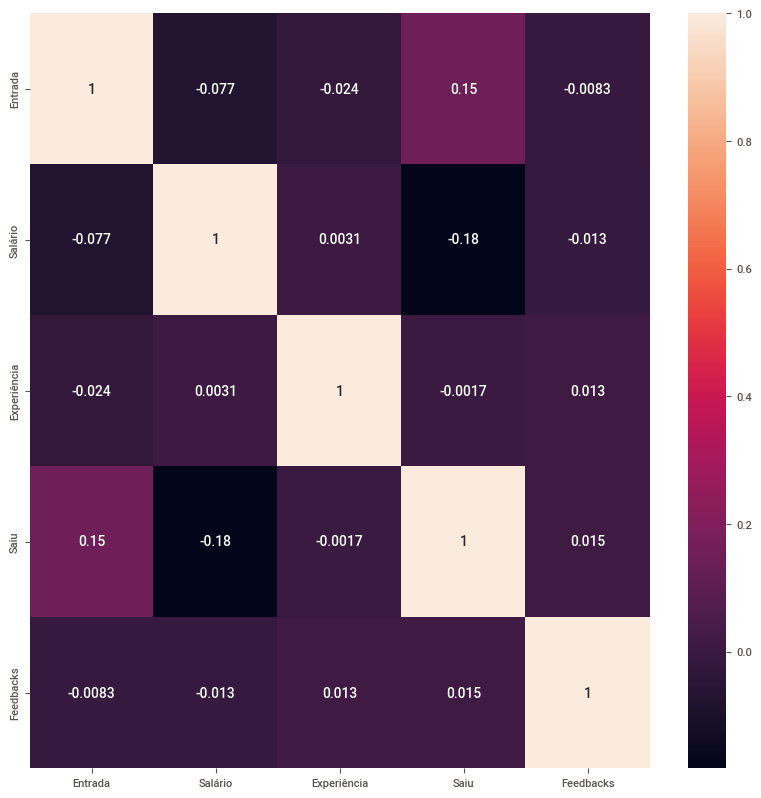

In [62]:
#Verificando se há correlação entre as features numéricas
plt.figure(figsize = [10,10])
sns.heatmap(ds_treino.corr(),annot = True)

Nota-se baixa correlação linear entre as features, o que evitaria problemas com alguns modelos, 
mas também há baixa correlação linear em relação a variável alvo, o que indica que métodos lineares não devem obter bons resultados.

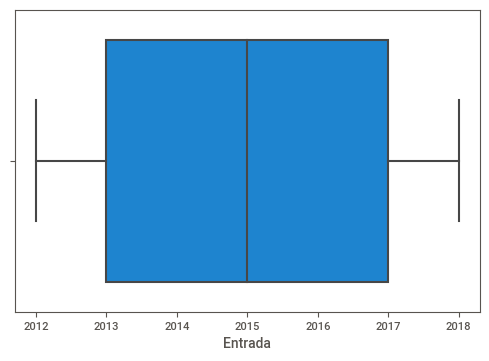

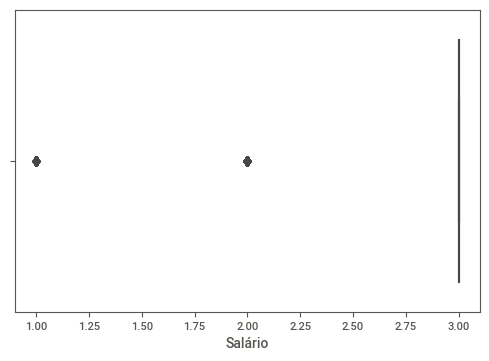

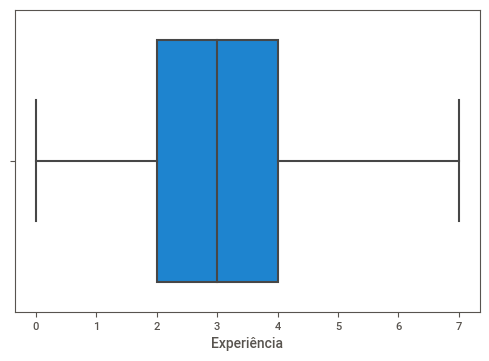

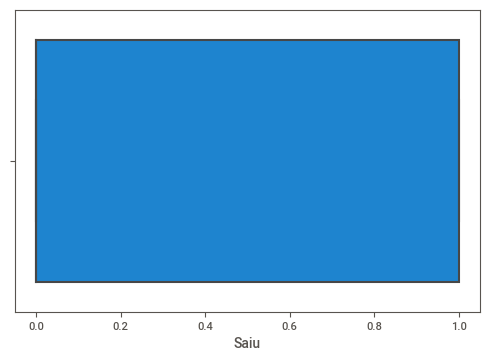

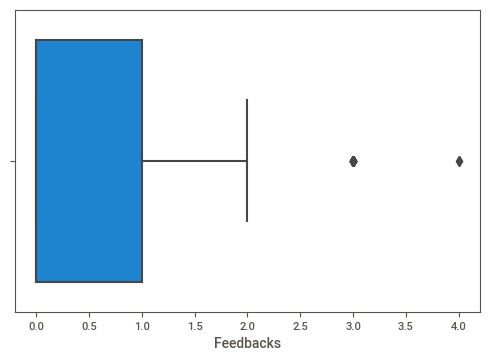

In [63]:
for i in ds_treino.corr().columns:
  sns.boxplot(x=ds_treino[i])
  plt.show()

##Tratamento de Dados

Testei algumas estratégias de tratamento dos dados porém mantive apenas a que obteve melhores resultados para não alongar a apresentação da solução.

In [65]:
def aux_Missing(x):
    if x == '---':
      return "outro"
    else:
      return x

def aux_salario(x):
    if x == 1:
      return 'A'
    elif x ==2:
      return 'B'
    else:
      return 'C'

In [66]:
treino = ds_treino.copy()

treino['Projeto']       = treino['Projeto'].apply(aux_Missing)
treino['Idade']         = treino['Idade'].apply(aux_Missing)
treino['Escolaridade']  = treino['Escolaridade'].apply(aux_Missing)
treino['Salário']       = treino['Salário'].apply(aux_salario)

In [67]:
#Dumificação de todas as variáveis
variaveis_toDummie        = ['Cidade','Sexo','Projeto','Salário', 'Entrada', 'Experiência', 'Feedbacks', 'Idade', 'Escolaridade']
treino = pd.get_dummies(treino, columns = variaveis_toDummie)

#A recomendação na aplicação da dumificação seria a utilização do parâmetro "drop_first = True", 
#porém tive problemas de divergência entre os campos que foram mantidos nas bases de Treino e de Teste,
#portanto optei por não utilizar o drop. 

In [68]:
treinoX = treino.drop(['Saiu'], axis = 1) 
treinoy = treino['Saiu']

In [69]:
treino.head()

,Saiu,Cidade_João Pessoa,Cidade_Natal,Cidade_Recife,Sexo_Feminino,Sexo_Masculino,Projeto_Não,Projeto_Sim,Projeto_outro,Salário_A,Salário_B,Salário_C,Entrada_2012,Entrada_2013,Entrada_2014,Entrada_2015,Entrada_2016,Entrada_2017,Entrada_2018,Experiência_0,Experiência_1,Experiência_2,Experiência_3,Experiência_4,Experiência_5,Experiência_6,Experiência_7,Feedbacks_0,Feedbacks_1,Feedbacks_2,Feedbacks_3,Feedbacks_4,Idade_22,Idade_23,Idade_24,Idade_25,Idade_26,Idade_27,Idade_28,Idade_29,Idade_30,Idade_31,Idade_32,Idade_33,Idade_34,Idade_35,Idade_36,Idade_37,Idade_38,Idade_39,Idade_40,Idade_41,Idade_outro,Escolaridade_Doutorado,Escolaridade_outro
0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [70]:
validacao = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)
resultados = CompareML(treinoX, treinoy, lista_de_modelosBase, nome_dos_modelosBase, validacao)
resultados.sort_values(by = 'f1-score', ascending = False)

Rodando modelo: Decision Tree
Rodando modelo: KNN
Rodando modelo: Randon Forest
Rodando modelo: Bagging
Rodando modelo: GaussianNB
Rodando modelo: GradientBoostingClassifier
Rodando modelo: LGBM
Rodando modelo: ADA


,acurácia,sensibilidade,precisão,eficiência,f1-score
GradientBoostingClassifier,0.778876,0.525001,0.822993,0.728380,0.640548
LGBM,0.765772,0.537196,0.770499,0.720301,0.632452
Randon Forest,0.746571,0.552557,0.709370,0.707982,0.620777
ADA,0.759913,0.501836,0.782758,0.708583,0.610694
Bagging,0.725002,0.542623,0.664794,0.688729,0.596944
Decision Tree,0.687894,0.551728,0.591813,0.660809,0.570546
KNN,0.713340,0.494535,0.658314,0.669822,0.564325
GaussianNB,0.512950,0.796269,0.470781,0.569261,0.554726


##Teste de Balanceamento

Devido ao desbalanceamento observado dos dados fiz um teste para verificação se alguma estratégia de balanceamento pode melhorar os resultados

In [71]:
rus = RandomUnderSampler()
over= RandomOverSampler(sampling_strategy='minority')

treinoXrus, treinoyrus = rus.fit_resample(treinoX, treinoy)
treinoXover, treinoyover = over.fit_resample(treinoX, treinoy)

validacao = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

In [72]:
#Under Sampler: Redução da classe com maior qtd
resultados = CompareML(treinoXrus, treinoyrus, lista_de_modelosBase, nome_dos_modelosBase, validacao)
resultados.sort_values(by = 'f1-score', ascending = False)

Rodando modelo: Decision Tree
Rodando modelo: KNN
Rodando modelo: Randon Forest
Rodando modelo: Bagging
Rodando modelo: GaussianNB
Rodando modelo: GradientBoostingClassifier
Rodando modelo: LGBM
Rodando modelo: ADA


,acurácia,sensibilidade,precisão,eficiência,f1-score
LGBM,0.704788,0.624539,0.744645,0.704794,0.678881
Randon Forest,0.698263,0.636040,0.726857,0.698269,0.678054
GradientBoostingClassifier,0.721121,0.583926,0.805665,0.721117,0.676342
ADA,0.702782,0.610504,0.749644,0.702780,0.672196
Bagging,0.678239,0.623624,0.700764,0.678226,0.659372
KNN,0.658266,0.625110,0.669868,0.658267,0.646346
Decision Tree,0.652323,0.633196,0.658789,0.652319,0.645335
GaussianNB,0.630363,0.579845,0.702943,0.630403,0.592956


In [73]:
#Over Sampler: Aumento da classe com menor qtd
resultados = CompareML(treinoXover, treinoyover, lista_de_modelosBase, nome_dos_modelosBase, validacao)
resultados.sort_values(by = 'f1-score', ascending = False)

Rodando modelo: Decision Tree
Rodando modelo: KNN
Rodando modelo: Randon Forest
Rodando modelo: Bagging
Rodando modelo: GaussianNB
Rodando modelo: GradientBoostingClassifier
Rodando modelo: LGBM
Rodando modelo: ADA


,acurácia,sensibilidade,precisão,eficiência,f1-score
Randon Forest,0.808297,0.804890,0.810828,0.808297,0.807631
Bagging,0.783104,0.785659,0.782192,0.783104,0.783652
Decision Tree,0.761401,0.788187,0.748480,0.761401,0.767580
LGBM,0.746209,0.660275,0.797671,0.746209,0.722183
KNN,0.704011,0.709011,0.702102,0.704011,0.705368
GradientBoostingClassifier,0.733599,0.578791,0.838703,0.733599,0.684585
ADA,0.707033,0.604341,0.760986,0.707033,0.673340
GaussianNB,0.570797,0.793022,0.593758,0.570797,0.640287


A 2 estratégias melhoraram os resultados obtidos, porém a Over Sampler se sobressaiu e passo a utilizar ela nos próximos testes.

##Seleção de Features

Utilização de método de seleção de features a partir das definição de importância pelo Randon Forest

In [74]:
modeloSelec = mod_rfor
dadosSelecX = treinoXover
dadosSelecy = treinoyover

modeloSelec.fit(dadosSelecX, dadosSelecy)
variaveis = pd.DataFrame()
variaveis['variavel'] = dadosSelecX.columns
variaveis['importância'] = modeloSelec.feature_importances_
variaveis.sort_values(by = 'importância', ascending = False, inplace = True)

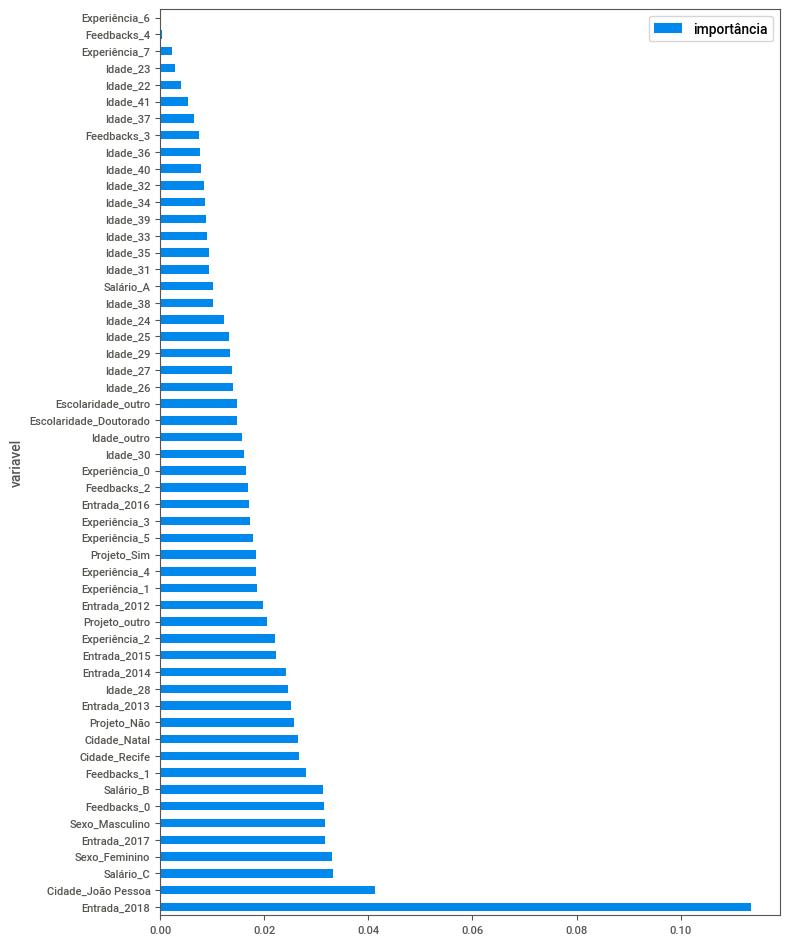

In [75]:
variaveis_graph =  variaveis.copy()
variaveis_graph.set_index('variavel', inplace = True)
variaveis_graph.plot(kind='barh', figsize=(8, 12));

In [76]:
features_import = pd.Series(data=variaveis['importância'].array, index=variaveis['variavel'].array)
features_import

Entrada_2018              0.113432
Cidade_João Pessoa        0.041250
Salário_C                 0.033110
Sexo_Feminino             0.033078
Entrada_2017              0.031688
Sexo_Masculino            0.031664
Feedbacks_0               0.031552
Salário_B                 0.031356
Feedbacks_1               0.028058
Cidade_Recife             0.026665
Cidade_Natal              0.026511
Projeto_Não               0.025678
Entrada_2013              0.025078
Idade_28                  0.024488
Entrada_2014              0.024163
Entrada_2015              0.022180
Experiência_2             0.022007
Projeto_outro             0.020577
Entrada_2012              0.019796
Experiência_1             0.018668
Experiência_4             0.018489
Projeto_Sim               0.018372
Experiência_5             0.017897
Experiência_3             0.017170
Entrada_2016              0.017154
Feedbacks_2               0.016956
Experiência_0             0.016539
Idade_30                  0.016161
Idade_outro         

In [77]:
validacao = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)
resultadosSelec = SelectFeatures(modeloSelec, dadosSelecX, dadosSelecy, validacao, features_import, 'f1')

In [78]:
best_p = 0
best_q = 0

for q in np.arange(len(resultadosSelec)):
  if resultadosSelec['Performance'][q] > best_p:
    best_p = resultadosSelec['Performance'][q]
    best_q = int(resultadosSelec['Qtd'][q])

In [79]:
print("Melhor Performance:", best_p)
print("com a Qtd de features:", best_q)

Melhor Performance: 0.8080165534789987
com a Qtd de features: 51


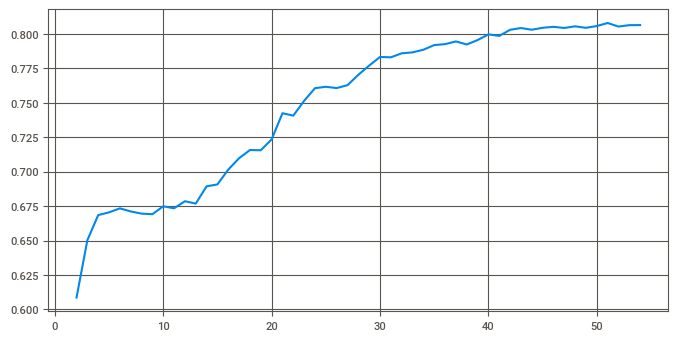

In [81]:
plt.figure(figsize = (8,4))
plt.grid()
plt.plot(resultadosSelec['Qtd'], resultadosSelec['Performance'])
plt.show()

A seleção de features não identificou um subconjunto com melhor performance relevante frente ao modelo com todas as features

##Hipertunagem de Parâmetros

In [82]:
validacao = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

testeTunModels = [
                  BaggingClassifier(), 
                  GradientBoostingClassifier(), 
                  AdaBoostClassifier(), 
                  RandomForestClassifier(), 
                  KNeighborsClassifier()

                 ]

testeTunParams = [
                  {
                   'n_estimators': [30, 50, 100],
                   'max_samples': [0.5, 1.0],
                   'bootstrap': [True],
                   'bootstrap_features': [False]
                  },
                  {
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2],
                   'max_depth' : [8, 10, 12],
                   'max_features': ['sqrt'],
                   'n_estimators': [75, 100, 125],
                   'learning_rate': np.arange(0.1, 1.0, 0.1)
                  },        
                  {
                    'n_estimators': [25, 50, 100],
                    'learning_rate': np.arange(1.0, 2.1, 0.1)
                  },                                  
                  {
                   'min_samples_split': [2, 5],
                   'min_samples_leaf': [1, 2],
                   'max_depth' : [5, 10, 15, 20, 25, 30],
                   'n_estimators': [80, 90, 100, 110, 120]
                  },
                  {
                    'n_neighbors': [3,5,7]
                  }
                 ]

In [83]:
dadosSelecX = treinoXover
dadosSelecy = treinoyover

for i in range(len(testeTunModels)):
  ret = Tunagem(testeTunModels[i], dadosSelecX, dadosSelecy, testeTunParams[i], validacao, 'f1')
  print(ret)

Fitting 50 folds for each of 6 candidates, totalling 300 fits
{'bestModel': BaggingClassifier(n_estimators=50), 'bestScore': 0.7946561805316221, 'bestParam': {'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0, 'n_estimators': 50}}
Fitting 50 folds for each of 486 candidates, totalling 24300 fits
{'bestModel': GradientBoostingClassifier(max_depth=12, max_features='sqrt'), 'bestScore': 0.797420187542896, 'bestParam': {'learning_rate': 0.1, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}}
Fitting 50 folds for each of 33 candidates, totalling 1650 fits
{'bestModel': AdaBoostClassifier(learning_rate=1.5000000000000004, n_estimators=25), 'bestScore': 0.6753558289945936, 'bestParam': {'learning_rate': 1.5000000000000004, 'n_estimators': 25}}
Fitting 50 folds for each of 120 candidates, totalling 6000 fits
{'bestModel': RandomForestClassifier(max_depth=30, n_estimators=90), 'bestScore': 0.8080834846295784, 'bestParam

Abaixo avalio os modelos Tunados em comparação com os modelos base e mais algumas variações

In [84]:
mod_bag        = BaggingClassifier()
mod_bagTun1    = BaggingClassifier(bootstrap=True, bootstrap_features=False, max_samples=1.0, n_estimators=50)
mod_bagTun2    = BaggingClassifier(bootstrap=True, bootstrap_features=False, max_samples=1.0, n_estimators=100)
mod_gbc        = GradientBoostingClassifier() 
mod_gbcTun1    = GradientBoostingClassifier(learning_rate=0.1, max_depth=12, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100) 
mod_gbcTun2    = GradientBoostingClassifier(learning_rate=0.5, max_depth=10, max_features="sqrt", min_samples_leaf=1, min_samples_split=5, n_estimators=100) 
mod_ada        = AdaBoostClassifier()
mod_adaTun1    = AdaBoostClassifier(learning_rate=1.5, n_estimators=25)
mod_adaTun2    = AdaBoostClassifier(learning_rate=1.6, n_estimators=100)
mod_rfor       = RandomForestClassifier()
mod_rforTun1   = RandomForestClassifier(max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=120)
mod_rforTun2   = RandomForestClassifier(max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=130)
mod_rforTun3   = RandomForestClassifier(max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators= 90)
mod_knn        = KNeighborsClassifier()
mod_knnTun     = KNeighborsClassifier(n_neighbors=3)

lista_de_modelosTun = [
      mod_bag     ,
      mod_bagTun1 ,
      mod_bagTun2 ,      
      mod_gbc     , 
      mod_gbcTun1 , 
      mod_gbcTun2 ,       
      mod_ada     ,
      mod_adaTun1 ,
      mod_adaTun2 ,      
      mod_rfor    ,
      mod_rforTun1,
      mod_rforTun2,
      mod_rforTun3,            
      mod_knn     ,
      mod_knnTun  
]

nome_dos_modelosTun = [
      'Bagging',
      'BaggingTun1',
      'BaggingTun2',      
      'GradientBoostingClassifier',
      'GradientBoostingClassifierTun1', 
      'GradientBoostingClassifierTun2',            
      'ADA',
      'ADATun1',
      'ADATun2',      
      'Randon Forest',
      'Randon ForestTun1', 
      'Randon ForestTun2', 
      'Randon ForestTun3',            
      'KNN',
      'KNNTun'
]

In [85]:
dadosSelecX = treinoXover
dadosSelecy = treinoyover
validacao = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

resultados = CompareML(dadosSelecX, dadosSelecy, lista_de_modelosTun, nome_dos_modelosTun, validacao)
resultados.sort_values(by = 'f1-score', ascending = False)

Rodando modelo: Bagging
Rodando modelo: BaggingTun1
Rodando modelo: BaggingTun2
Rodando modelo: GradientBoostingClassifier
Rodando modelo: GradientBoostingClassifierTun1
Rodando modelo: GradientBoostingClassifierTun2
Rodando modelo: ADA
Rodando modelo: ADATun1
Rodando modelo: ADATun2
Rodando modelo: Randon Forest
Rodando modelo: Randon ForestTun1
Rodando modelo: Randon ForestTun2
Rodando modelo: Randon ForestTun3
Rodando modelo: KNN
Rodando modelo: KNNTun


,acurácia,sensibilidade,precisão,eficiência,f1-score
Randon ForestTun3,0.809835,0.804121,0.813838,0.809835,0.808729
Randon Forest,0.809066,0.805330,0.811581,0.809066,0.808280
Randon ForestTun1,0.809396,0.800549,0.815197,0.809396,0.807591
BaggingTun2,0.793379,0.802912,0.788070,0.793379,0.795279
GradientBoostingClassifierTun1,0.796071,0.790385,0.799877,0.796071,0.794820
BaggingTun1,0.790577,0.800275,0.785356,0.790577,0.792502
GradientBoostingClassifierTun2,0.787005,0.795330,0.782654,0.787005,0.788723
Bagging,0.780440,0.783516,0.779004,0.780440,0.781007
Randon ForestTun2,0.772088,0.653077,0.857409,0.772088,0.740984
KNNTun,0.729011,0.701868,0.742457,0.729011,0.721415


##Combinação de Modelos

Teste de combinação de modelos visando não somente o aumento do F1-score no cross validation como também combinar modelos de maior Sensibilidade e de maior Precisão para obter uma maior confiabilidade do resultado.
Durante a competição testei diversas combinações, abaixo segue as mais relevantes.

In [86]:
validacao = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)
dadosSelecionadosX = treinoXover
dadosSelecionadosy = treinoyover

In [88]:
modelos = [('GradientBoostingClassifier', mod_gbcTun1), ('KNN', mod_knnTun), ('Bagging', mod_bagTun2), ('RandomForestClassifier', mod_rforTun3)]

# Combinação 'Hard'
modelo_h = VotingClassifier(modelos, voting = 'hard')
medidas_h = cross_validate(modelo_h, dadosSelecionadosX, dadosSelecionadosy, cv = validacao, scoring = 'f1')
print('Hard:'+ str(medidas_h['test_score'].mean()))

# Combinação 'Soft'
modelo_s = VotingClassifier(modelos, voting = 'soft')
medidas_s = cross_validate(modelo_s, dadosSelecionadosX, dadosSelecionadosy, cv = validacao, scoring = 'f1')
print('Soft:'+ str(medidas_s['test_score'].mean()))

Hard:0.8042515356664777
Soft:0.802081900590164


In [89]:
modelos= [('GradientBoostingClassifier', mod_gbcTun1), ('Bagging', mod_bagTun1), ('RandomForestClassifier', mod_rforTun2), ('RandomForestClassifier 3', mod_rforTun3)]

# Combinação 'Hard'
modelo_h = VotingClassifier(modelos, voting = 'hard')
medidas_h = cross_validate(modelo_h, dadosSelecionadosX, dadosSelecionadosy, cv = validacao, scoring = 'f1')
print('Hard:'+ str(medidas_h['test_score'].mean()))

# Combinação 'Soft'
modelo_s = VotingClassifier(modelos, voting = 'soft')
medidas_s = cross_validate(modelo_s, dadosSelecionadosX, dadosSelecionadosy, cv = validacao, scoring = 'f1')
print('Soft:'+ str(medidas_s['test_score'].mean()))

Hard:0.8063198550281362
Soft:0.8017067758147586


In [90]:
modelos = [('Bagging', mod_bagTun1), ('RandomForestClassifier 2', mod_rforTun2), ('RandomForestClassifier 3', mod_rforTun3)]

# Combinação 'Hard'
modelo_h = VotingClassifier(modelos, voting = 'hard')
medidas_h = cross_validate(modelo_h, dadosSelecionadosX, dadosSelecionadosy, cv = validacao, scoring = 'f1')
print('Hard:'+ str(medidas_h['test_score'].mean()))

# Combinação 'Soft'
modelo_s = VotingClassifier(modelos, voting = 'soft')
medidas_s = cross_validate(modelo_s, dadosSelecionadosX, dadosSelecionadosy, cv = validacao, scoring = 'f1')
print('Soft:'+ str(medidas_s['test_score'].mean()))

Hard:0.8103811333114325
Soft:0.8049933498223176


##Modelo Final e Submissão

In [91]:
fonte_saida = ds_teste.copy()

fonte_saida['Projeto']       = fonte_saida['Projeto'].apply(aux_Missing)
fonte_saida['Idade']         = fonte_saida['Idade'].apply(aux_Missing)
fonte_saida['Escolaridade']  = fonte_saida['Escolaridade'].apply(aux_Missing)
fonte_saida['Salário']       = fonte_saida['Salário'].apply(aux_salario)

variaveis_toDummie        = ['Cidade','Sexo','Projeto','Salário', 'Entrada', 'Experiência', 'Feedbacks', 'Idade', 'Escolaridade']
fonte_saida = pd.get_dummies(fonte_saida, columns = variaveis_toDummie)

In [92]:
dadosSelecionadosX = treinoXover
dadosSelecionadosy = treinoyover

modelo_decidido = VotingClassifier([('Bagging', mod_bagTun1), ('RandomForestClassifier 2', mod_rforTun2), ('RandomForestClassifier 3', mod_rforTun3)], voting = 'hard')
modelo_decidido.fit(dadosSelecionadosX,dadosSelecionadosy)

VotingClassifier(estimators=[('Bagging', BaggingClassifier(n_estimators=50)),
                             ('RandomForestClassifier 2',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=130)),
                             ('RandomForestClassifier 3',
                              RandomForestClassifier(max_depth=30,
                                                     n_estimators=90))])

In [93]:
#F1 da predição sobre os dados de Treino
preditos = modelo_decidido.predict(dadosSelecionadosX)
f1 = f1_score(dadosSelecionadosy, preditos)
f1

0.943876140447885

In [94]:
pred = modelo_decidido.predict(fonte_saida)

subm = pd.DataFrame()
subm['Saiu'] = pred
subm.to_csv('submissao.csv', index = False)

In [95]:
from google.colab import files
files.download("submissao.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>